<a href="https://colab.research.google.com/github/sammyfow/cap-comp215/blob/2024.01/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from scipy.signal import correlate2d

%matplotlib inline
# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

In [2]:
def plot_2D_array(array, axes=None, title='', cmap='Blues', **options):
  axes = axes or plt.gca()
  axes.set_title(title)
  axes.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                   labelbottom=False, labeltop=False, labelleft=False, labelright=False,)
  options = {**dict(interpolation='nearest', origin='upper'), **options}
  axes.imshow(array, cmap=cmap, **options)

In [50]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number
    """

    def __init__(self, model, frames=50, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            self.model.step()
        self.model.draw(self.ax, step=step)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()          # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)     # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()               # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

In [58]:
class ant:


  def __init__(self, y, x, direction, size):
    self.direction = direction
    self.x = x
    self.y = y
    self.position = (self.y, self.x)
    self.grid = np.zeros((size, size), dtype=np.uint8)

  def turn_right(self):
    self.direction = (self.direction + 1) % 4

  def turn_left(self):
    self.direction = (self.direction - 1) % 4

  def move_forward(self):
    if self.direction == 0:
      self.y += -1
    elif self.direction == 1:
      self.x += 1
    elif self.direction == 2:
      self.y += 1
    elif self.direction == 3:
      self.x += -1

  def step(self):
    if self.grid[self.y, self.x] == 0:
      self.grid[self.y, self.x] += 1
      self.turn_left()
      self.move_forward()
    elif self.grid[self.y, self.x] == 1:
      self.grid[self.y, self.x] += -1
      self.turn_right()
      self.move_forward()

  def draw(self, axes=None, step=''):
    axes = axes or plt.gca()
    plot_2D_array(self.grid, axes, title='')






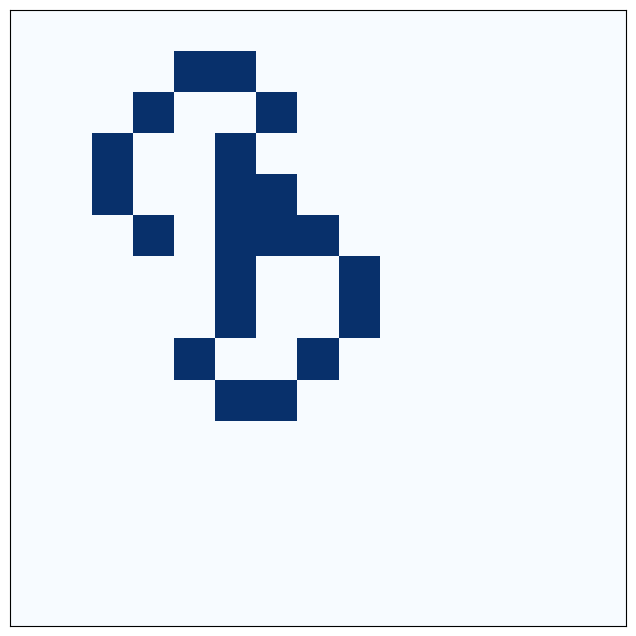

In [60]:
test = ant(5, 5, 0, 15)
anim = Animation2D(test, 100)
anim.animate()